In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
l2=1e-7
lr=0.005
n_epochs=80

In [3]:
RUN_NAME = "foo7"
NUM_SLICES = 5
K = 2
M = 20
N = 5000
unipolar = False

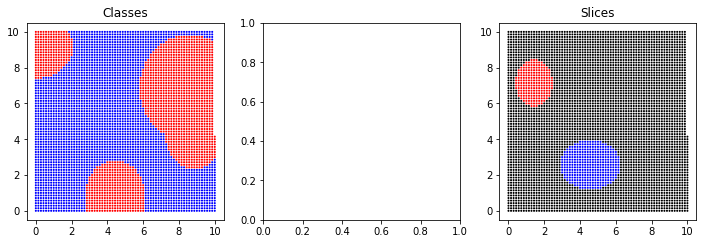

In [4]:
L, X, Y, Z = generate_dataset(
    K, M, N, 
    unipolar=unipolar,
    L_kwargs=({'max_r': 7} if unipolar else {'max_r': 5}),
    Z_kwargs={'num_slices': NUM_SLICES},
)

### Analyze Data

In [5]:
from scipy.sparse import csr_matrix
import torch

L = csr_matrix(L)
X = torch.Tensor(X)

In [6]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, 
                            splits=[0.5, 0.25, 0.25], 
                            shuffle=True, seed=123)

In [7]:
from metal.analysis import lf_summary

df = lf_summary(Ls[1], Ys[1])
df

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.0296,0.0256,0.0136,29,8,0.783784
1,"[1, 2]",0.2864,0.2800,0.2216,242,116,0.675978
2,"[1, 2]",0.1552,0.1552,0.1384,127,67,0.654639
3,"[1, 2]",0.2816,0.2592,0.1840,277,75,0.786932
4,"[1, 2]",0.2224,0.2176,0.1576,175,103,0.629496
5,"[1, 2]",0.0624,0.0600,0.0480,39,39,0.500000
6,"[1, 2]",0.4728,0.4704,0.3688,451,140,0.763113
7,"[1, 2]",0.2656,0.2608,0.1864,256,76,0.771084
8,"[1, 2]",0.3256,0.3144,0.2432,268,139,0.658477
9,"[1, 2]",0.1120,0.1112,0.0872,93,47,0.664286


In [8]:
df.mean()

Coverage       0.184000
Overlaps       0.179440
Conflicts      0.137800
Correct      160.900000
Incorrect     69.100000
Emp. Acc.      0.714913
dtype: float64

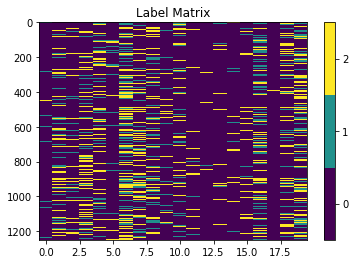

In [9]:
from metal.contrib.visualization.analysis import view_label_matrix

view_label_matrix(Ls[1])

In [10]:
# num_votes = Ls[0].sum(axis=1)
# plt.hist(num_votes)

In [11]:
# np.save('synthetic_data.npy', (L, Y))

### Add pepper

In [12]:
# from collections import Counter

# Ls[0]

In [13]:
# df = lf_summary(Ls[1], Ys[1])
# df.mean()

In [14]:
# view_label_matrix(L)

In [15]:
# from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
# from metal.contrib.slicing.utils import add_pepper

# for pepper in [0, 0.05, 0.1, 0.2, 0.5]:
#     print(pepper)
#     L_temp = add_pepper(Ls[0], pepper)

#     label_model = SnorkelLabelModel()
#     label_model.train_model(L_temp)

#     label_model.score((Ls[1], Ys[1]))

# Learn

In [16]:
# L, Y = np.load('synthetic_data.npy')

### Snorkel LabelModel

In [17]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

In [18]:
from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Y_train_p = label_model.predict(Ls[0])

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.7664

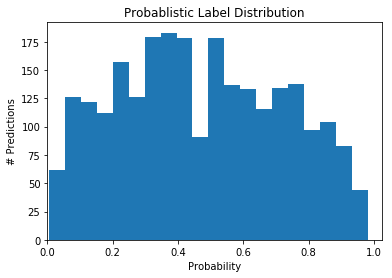

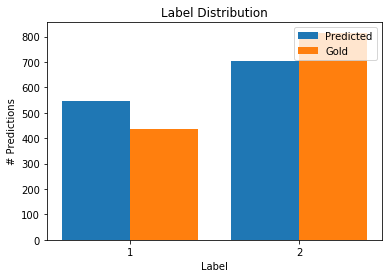

In [19]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)
    
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

## Compare Baselines

In [20]:
# from torch.utils.data import DataLoader
# from metal.utils import SlicingDataset
# from metal.contrib.slicing.utils import evaluate_slicing

# eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

# results = {}
# for model_name, model in trained_models.items():
#     scores = evaluate_slicing(model, eval_loader, verbose=False)
#     results[model_name] = {k:v['accuracy'] for k,v in scores.items()}
    
# import pandas as pd
# pd.DataFrame.from_dict(results)

In [21]:
from metal.end_model import EndModel
end_model = EndModel([2,10,10,2])


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)



### EndModel

In [22]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

train_loader = DataLoader(
    SlicingDataset(Xs[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

In [23]:
import torch
from metal.contrib.logging.tensorboard import TensorBoardWriter

logger = TensorBoardWriter(log_dir='checkpoints', run_dir='dp', run_name=RUN_NAME)

end_model.train_model(
    train_loader, 
    dev_data=(Xs[1], Ys[1]), 
    l2=l2, 
    lr=lr,
    n_epochs=n_epochs, 
    print_every=10, 
    log_writer=logger,
    validation_metric='accuracy', 
    disable_prog_bar=True
)
end_model.score((Xs[1], Ys[1]))

Saving model at iteration 0 with best score 0.726
[E:0]	Train Loss: 0.685	Dev accuracy: 0.726
Saving model at iteration 2 with best score 0.729
Saving model at iteration 5 with best score 0.775
Saving model at iteration 6 with best score 0.786
Saving model at iteration 7 with best score 0.790
Saving model at iteration 8 with best score 0.811
Saving model at iteration 9 with best score 0.812
[E:10]	Train Loss: 0.662	Dev accuracy: 0.802
Saving model at iteration 12 with best score 0.820
Saving model at iteration 13 with best score 0.848
Saving model at iteration 15 with best score 0.860
Saving model at iteration 17 with best score 0.869
Saving model at iteration 19 with best score 0.870
[E:20]	Train Loss: 0.656	Dev accuracy: 0.864
Saving model at iteration 21 with best score 0.889
Saving model at iteration 26 with best score 0.897
[E:30]	Train Loss: 0.653	Dev accuracy: 0.890
Saving model at iteration 31 with best score 0.902
[E:40]	Train Loss: 0.652	Dev accuracy: 0.898
Saving model at it

0.9032

## Slice Family

In [24]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

dev_loader = DataLoader(
    SlicingDataset(Xs[1], Ys[1]),
    batch_size=256,
)

### SliceModel

In [25]:
# import torch.nn as nn
# from metal.contrib.slicing.online_dp import SliceDPModel, MLPModule
# from metal.contrib.logging.tensorboard import TensorBoardWriter

# logger = TensorBoardWriter(log_dir='checkpoints', run_dir='slice_orig')


# n, m = Ls[0].shape
# input_dim = Xs[0].shape[1]

# input_module = MLPModule(input_dim, 10, [10], bias=True)
# slice_orig = SliceDPModel(input_module, r=10, m=m, reweight=False, slice_weight=0.1, 
#                            verbose=False)
# slice_orig.train_model(
#     train_loader,
#     dev_data=dev_loader,
#     l2=0.0, 
#     n_epochs=40,
#     print_every=5, 
#     validation_metric='accuracy',
#     log_writer=logger,
#     verbose=True, 
#     use_cuda=False,
#     disable_prog_bar=True,
# )

### SliceHatModel

In [26]:
from metal.contrib.slicing.online_dp import SliceHatModel
from metal.contrib.logging.tensorboard import TensorBoardWriter

logger = TensorBoardWriter(log_dir='checkpoints', run_dir='slice_hat', run_name=RUN_NAME)

slice_hat = SliceHatModel(end_model, M, slice_weight=0.1)

slice_hat.train_model(
    train_loader,
    dev_data=dev_loader,
    l2=l2, 
    lr=lr,
    n_epochs=n_epochs, 
    print_every=10, 
    validation_metric='accuracy',
    log_writer=logger,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

Resetting base model parameters
SliceHatModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=10, out_features=20, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

Saving model at iteration 0 with best score 0.730
[E:0]	Train Loss: 0.634	Dev accuracy: 0.730
Saving model at iteration 1 with best score 0.735
Saving model at iteration 6 with best score 0.762
Saving model at iteration 7 with best score 0.768
Saving model at iteration 9 with best score 0.790
[E:10]	Train Loss: 0.610	Dev accuracy: 0.761
Saving model at iteration 14 with best score 0.816
Saving model at iteration 17 with best score 0.818
[E:20]	Train Loss: 0.606	Dev accuracy: 0.8

### SliceOnlineModel

In [27]:
from metal.contrib.slicing.online_dp import SliceOnlineModel
from metal.contrib.logging.tensorboard import TensorBoardWriter

logger = TensorBoardWriter(log_dir='checkpoints', run_dir='slice_online', run_name=RUN_NAME)

slice_online = SliceOnlineModel(end_model, M, L_head_weight=0.1, Y_head_weight=0.1)

slice_online.train_model(
    train_loader,
    dev_data=dev_loader,
    l2=l2, 
    lr=lr,
    n_epochs=n_epochs, 
    print_every=10, 
    validation_metric='accuracy',
    log_writer=logger,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

Resetting base model parameters
SliceOnlineModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=10, out_features=20, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=10, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=20, out_features=1, bias=True)
)

Saving model at iteration 0 with best score 0.631
[E:0]	Train Loss: 0.638	Dev accuracy: 0.631
Saving model at iteration 1 with best score 0.722
Saving model at iteration 2 with best score 0.728
Saving model at iteration 3 with best score 0.752
Saving model at iteration 5 with best score 0.766
[E:10]	Train Loss: 0.614	Dev accuracy: 0.754
Saving model at iteration 12 with best score 0.767
Saving model at iteration

## Evaluation

In [28]:
from collections import defaultdict

from metal.contrib.slicing.experiment_utils import eval_model

from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

eval_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]))

history = defaultdict(list)
history['dp'].append(eval_model(end_model, eval_loader, verbose=False))
# history['slice_orig'].append(eval_model(slice_orig, eval_loader, verbose=False))
history['slice_hat'].append(eval_model(slice_hat, eval_loader, verbose=False))
history['slice_online'].append(eval_model(slice_online, eval_loader, verbose=False))


SUMMARY (accuracies):
All: 0.904
Slice 0: 0.905693950177936
Slice 1: 0.8363636363636363
Slice 2: 0.9295774647887324

SUMMARY (accuracies):
All: 0.8632
Slice 0: 0.8727758007117438
Slice 1: 0.9454545454545454
Slice 2: 0.647887323943662

SUMMARY (accuracies):
All: 0.8328
Slice 0: 0.8425266903914591
Slice 1: 0.8727272727272727
Slice 2: 0.647887323943662


In [29]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n=1):")
df = parse_history(history, NUM_SLICES)
df

Average (n=1):


,dp,slice_hat,slice_online
all,0.904000,0.863200,0.832800
slice_1,0.836364,0.945455,0.872727
slice_2,0.929577,0.647887,0.647887
slice_avg,0.882971,0.796671,0.760307


In [30]:
# L_pred = np.round(slicer.predict_L_proba(Xs[1]).numpy())
# L_pred[L_pred == 0] = 2
# accuracy_score(Ls[1].reshape(-1,1), L_pred.reshape(-1,1), ignore_in_gold=[0])

In [31]:
# ((Ls[1] == L_pred).sum(axis=0)/(Ls[1] != 0).sum(axis=0)).mean()

In [32]:
# from metal.label_model import LabelModel
# label_model = LabelModel()
# label_model.train_model(Ls[0], n_epochs=500, print_every=20)
# label_model.score((Ls[1], Ys[1]))

# Y_train = label_model.predict_proba(Ls[0])
# Ys[0] = Y_train